# BIGFOOT vs UFO
* Exploration of webscraped data with Beautiful Soup.
* Configuring functions to convert bigfoot and ufo data.
    * Requiring individualized functions.
* Dealing with nans and class imbalance
* Classification
    * Countvectorizer and Tfidfvectorizer
    * Train test split
    * Naïve Bayes
        * Bernoulli
        * Multinomial
    * Random Forest
    * Roc-auc curves and scores

### Reading and parsing json files containing html content
See the [BeautifulSoup documentation](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
import json # to work with json file format
from bs4 import BeautifulSoup # to parse html

## Exploring bigfoot data with Beautiful Soup

In [4]:
# TODO: this doesn't scale well and doesn't help with looking at the data.
#       Possible solutions: load into pandas dataframe or mongodb, maybe both.
records = []
with open('data/bigfoot_first100records.json') as f:
    print(type(f))
    for i in f:
#         print(i)
#         print(type(i))
        records.append(json.loads(i))

<class '_io.TextIOWrapper'>


In [5]:
type('i') == str

True

In [6]:
# Create URL to JSON file (alternatively this can be a filepath)
path = 'data/bigfoot_first100records.json'


json_df = pd.read_json(path, lines=True)

# this is what the df looks like
json_df


,_id,url,html,time
0,{'$oid': '5939abbd2acdf6607095366c'},show_report.asp?id=13038,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:40 2017
1,{'$oid': '5939abbd2acdf6607095366d'},show_report.asp?id=8792,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
2,{'$oid': '5939abbd2acdf6607095366e'},show_report.asp?id=1255,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
3,{'$oid': '5939abbd2acdf6607095366f'},show_report.asp?id=11616,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:41 2017
4,{'$oid': '5939abbe2acdf66070953670'},show_report.asp?id=637,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:55:42 2017
...,...,...,...,...
94,{'$oid': '5939abdb2acdf660709536ca'},show_report.asp?id=17480,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:56:11 2017
95,{'$oid': '5939abdb2acdf660709536cb'},show_report.asp?id=1419,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:56:11 2017
96,{'$oid': '5939abdb2acdf660709536cc'},show_report.asp?id=25238,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:56:11 2017
97,{'$oid': '5939abdc2acdf660709536cd'},show_report.asp?id=44487,"\r\n<!doctype html public ""-//w3c//dtd html 4....",Thu Jun 8 19:56:12 2017


In [7]:
type(json_df.html[0])

str

In [8]:
# key: 'html', value: 0
# big, messy string
# json_df.html[0] # long string

In [9]:
type(records[0]['_id'])

dict

In [10]:
# show the first record, which is a dict
# big, messy dict
# records[0]

In [11]:
# records is a dict
# keys of the dict record
records[0].keys()

dict_keys(['_id', 'url', 'html', 'time'])

In [12]:
# finds each key in json file for that record
print(records[0].keys(), '\n')

# prints each key and value (using f strings)
# for k, v in records[0].items():
#     print(f'KEY: {k} \nVALUE: {v} \n')

dict_keys(['_id', 'url', 'html', 'time']) 



In [13]:
# use BeautifulSoup to parse the html
soup = BeautifulSoup(records[0]['html'], 'html.parser')
type(soup.get_text())

str

In [14]:
# messy, just text portion of html string
# soup.get_text()

In [15]:
# print(soup.prettify())

In [16]:
print(soup.title)
print(soup.title.text)

<title>BFRO Report 13038: Snowmobiler has encounter in deep snow near Potter, AK</title>
BFRO Report 13038: Snowmobiler has encounter in deep snow near Potter, AK


In [17]:
# filtering by class and attribute
soup.find_all('span', {'class': 'field'})

[<span class="field">Submitted  by  witness   on Saturday, November 12, 2005.</span>,
 <span class="field">Snowmobiler has encounter in deep snow near Potter, AK</span>,
 <span class="field">YEAR:</span>,
 <span class="field">SEASON:</span>,
 <span class="field">MONTH:</span>,
 <span class="field">STATE:</span>,
 <span class="field">COUNTY:</span>,
 <span class="field">LOCATION DETAILS:</span>,
 <span class="field">NEAREST TOWN:</span>,
 <span class="field">NEAREST ROAD:</span>,
 <span class="field">OBSERVED:</span>,
 <span class="field">ALSO NOTICED:</span>,
 <span class="field">OTHER WITNESSES:</span>,
 <span class="field">OTHER STORIES:</span>,
 <span class="field">TIME AND CONDITIONS:</span>,
 <span class="field">ENVIRONMENT:</span>]

In [20]:
# using tag p (paragraph)
# soup.find_all('p')

In [21]:
# testing out my first conversions to df
soup1 = BeautifulSoup(records[0]['html'], 'html.parser')
soup2 = BeautifulSoup(records[1]['html'], 'html.parser')
    
df1 = pd.DataFrame([p.text.split(': ') for p in soup1.find_all("p") if len(p.text.split(': ')) > 1]).T
df1 = df1.rename(columns=df1.loc[0]).drop(0)
df2 = pd.DataFrame([p.text.split(': ') for p in soup2.find_all("p") if len(p.text.split(': ')) > 1]).T
df2 = df2.rename(columns=df2.loc[0]).drop(0)

pd.concat([df1,df2])


,YEAR,SEASON,MONTH,STATE,COUNTY,LOCATION DETAILS,NEAREST TOWN,NEAREST ROAD,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT,DATE
1,2004,Winter,February,Alaska,Anchorage County,Up near powerline clearings east of Potter Mar...,Anchorage / Hillside,No real roads in the area,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",My two friends were snowmachining behind me bu...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove...",NaN
1,2003,Winter,December,Alaska,Anchorage County,"Few houses on the way, a power relay station. ...",Anchorage,Dowling,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...","4. Me, w-man, warren and sean. We were at my h...",no,"Started at 11, ended at about 3-3:30. Weather ...","A pine forest, with a bog or swamp on the righ...",Friday night


In [23]:
# incrementally building res_df up to record 28, which gives KeyError: 0
res_df = pd.DataFrame()
# soup1 = BeautifulSoup(records[0]['html'], 'html.parser')
# df1 = pd.DataFrame([p.text.split(': ') for p in soup1.find_all("p") if len(p.text.split(': ')) > 1]).T
# df1 = df1.rename(columns=df1.loc[0]).drop(0)
# if res_df.empty:
# #     print("yup")
#     res_df = pd.DataFrame(df1)
count = 0
for i in range(28):
#     print('\n',count,'\n')
    soup = BeautifulSoup(records[i]['html'], 'html.parser')
#     print(soup)
    
    df = pd.DataFrame([p.text.split(': ') for p in soup.find_all("p") if len(p.text.split(': ')) > 1]).T
    df = df.rename(columns=df.loc[0]).drop(0)
#     print(df)
    if res_df.empty:
#         print("yup")
        res_df = pd.DataFrame(df)
    else:
        res_df = pd.concat([res_df, df])
    count += 1
# res_df

In [22]:
# testing individual records
# test 28, which is creating KeyError: 0
soup28 = BeautifulSoup(records[28]['html'], 'html.parser')
df28 = pd.DataFrame([p.text.split(': ') for p in soup28.find_all("p") if len(p.text.split(': ')) > 1] ).T

# df28 = df28.rename(columns=df28.loc[0]).drop(0) # this causes error, because there is only one row
df28.shape

(0, 0)

In [24]:
# code blocks needed to build records list of json records for first100 records of bigfoot data or entire bigfoot data

# bigfoot_first100records
# records = []
# with open('data/bigfoot_first100records.json') as f:
#     print(type(f))
#     for i in f:
# #         print(i)
# #         print(type(i))
#         records.append(json.loads(i))

# # full_data - bigfoot_data
# # create list of dict
# full_data = []
# with open('data/bigfoot_data.json') as f:
# #     print(type(f))
#     for i in f:
#         full_data.append(json.loads(i))

## Final function to convert bigfoot data to dataframe

In [25]:
# final function to convert to dataframe for bigfoot data
def convert_to_dataframe(records):
    # outside loop, instantiate empty df to increment 
    df = pd.DataFrame()
    for record in records:
        soup = BeautifulSoup(record['html'], 'html.parser')

        # split each p.text in soup on ': ', then transform
        temp_df = pd.DataFrame([p.text.split(': ') for p in soup.find_all("p") if len(p.text.split(': ')) > 1 and ': ' in p.text]).T # and condition to pass exception

        # exception for df with no columns
        if temp_df.shape[0] < 2:
            continue

        # assign columns to row 0 values, drop row 0
        temp_df = temp_df.rename(columns=temp_df.loc[0]).drop(0)
        
        # one time step to populate df
        if df.empty:
            df = pd.DataFrame(temp_df)

        else:
            df = pd.concat([df, temp_df])
    
    return df

df = convert_to_dataframe(records)

In [27]:
# clean up bigfoot df columns
subset = ['YEAR', 'SEASON', 'MONTH', 'STATE', 'COUNTY', 'OBSERVED', 'ALSO NOTICED',
       'OTHER WITNESSES', 'OTHER STORIES', 'TIME AND CONDITIONS',
       'ENVIRONMENT']
# only columns with useful data
ss = df[subset]
# only row 1 for odd exceptions where there was more than one row while incrementing
ss = ss.loc[1]
ss = ss.fillna('Unknown')
# pretty clean subset
ss

,YEAR,SEASON,MONTH,STATE,COUNTY,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT
1,2004,Winter,February,Alaska,Anchorage County,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",My two friends were snowmachining behind me bu...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove..."
1,2003,Winter,December,Alaska,Anchorage County,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...","4. Me, w-man, warren and sean. We were at my h...",no,"Started at 11, ended at about 3-3:30. Weather ...","A pine forest, with a bog or swamp on the righ..."
1,1998,Fall,September,Alaska,Bethel County,My hunting buddy and I were sitting on a ridge...,nothing unusual,Scouting for caribou with high quality binocul...,Unknown,Unknown,Call Iliamna Air taxi for lat & Long of Long L...
1,2004,Summer,July,Alaska,Bristol Bay County,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,"One other witness, and he was fishing prior to...","I've only heard of one other story, from an ol...","Approximately 12:30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ..."
1,2000,Summer,June,Alaska,Cordova-McCarthy County,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,"I was the only witness, there was one other in...",None,About 12:00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...
...,...,...,...,...,...,...,...,...,...,...,...
1,2005,Summer,June,Alabama,Talladega County,Every year me and a group of my friends camp ...,the year before this icident we heard the nois...,"There where five other witnesses, and we where...",Unknown,"night time, clear skys, no wind","mountain like terrain, very lush vegitation, c..."
1,2000,Summer,July,Alabama,Talladega County,"My husband, myself and my husbands friend were...",Sounds of trees or brush moving.,3 people present talking and walking toward th...,None,"1:00 or 2:00 AM. Weather was clear, was a Full...",Narrow steep trail pine trees near salt creek....
1,1999,Fall,Unknown,Alabama,Talladega County,Unknown,sir when i came around the curve bigfoot was ...,my oldest daughter was in the front seat,no,11pm at night,talledaga natinal forest in alabama
1,1967,Summer,Unknown,Alabama,Tallapoosa County,"Not a good writer, but what happened to me and...",Unknown,just me that saw it,no,about 1 in the afternoon,"pines, bushes, near road and swampy down in ho..."


In [28]:
# create list of dict
full_data = []

with open('data/bigfoot_data.json') as f:
#     print(type(f))
    for i in f:
        full_data.append(json.loads(i))
        

In [29]:
# list of dict
type(full_data)

list

In [30]:
# takes about 5 or so minutes to run
full_df = convert_to_dataframe(full_data)

In [31]:
full_df.shape

(6193, 588)

In [32]:
# lot of extra columns, apparently commentary on witness observation and not necessary
full_df.columns

Index(['YEAR', 'SEASON', 'MONTH', 'STATE', 'COUNTY', 'LOCATION DETAILS',
       'NEAREST TOWN', 'NEAREST ROAD', 'OBSERVED', 'ALSO NOTICED',
       ...
       'The witness was interviewed by phone on the evening of 01/09/08 and provided the following additional information/observations:The creature crossed the road casually, as if not in a hurry or concerned by the witness' on-coming vehicle.  It took all of 3 steps for the creature to cross the two-lane highway.  The motion was fluid and consistent with natural locomotion.  Estimating height and weight, the witness concluded that the creature was no less than six feet tall, stocky, with a weight of at least 400lbs.  Hair/fur appeared dark in colour with a reddish hue, perhaps 2 inches in length.  Facial features were not noted.  The area of the sighting is just outside Fort Frances where boreal forests, farms, a few residential homes, a lumber yard, and storage facility dot the landscape.  The creature exited the forest on the south si

In [37]:
# trim away messy, unnecessary columns
subset = ['YEAR', 'SEASON', 'MONTH', 'STATE', 'COUNTY', 'OBSERVED', 'ALSO NOTICED',
       'OTHER WITNESSES', 'OTHER STORIES', 'TIME AND CONDITIONS',
       'ENVIRONMENT']
# only columns with useful data
full_ss = full_df[subset]
# only row 1 for odd exceptions where there was more than one row while incrementing
full_ss = full_ss.loc[1]
# filling all NaNs with 'Unknown'
full_ss = full_ss.fillna('Unknown')
# pretty clean subset
full_ss

,YEAR,SEASON,MONTH,STATE,COUNTY,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT
1,2004,Winter,February,Alaska,Anchorage County,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",My two friends were snowmachining behind me bu...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove..."
1,2003,Winter,December,Alaska,Anchorage County,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...","4. Me, w-man, warren and sean. We were at my h...",no,"Started at 11, ended at about 3-3:30. Weather ...","A pine forest, with a bog or swamp on the righ..."
1,1998,Fall,September,Alaska,Bethel County,My hunting buddy and I were sitting on a ridge...,nothing unusual,Scouting for caribou with high quality binocul...,Unknown,Unknown,Call Iliamna Air taxi for lat & Long of Long L...
1,2004,Summer,July,Alaska,Bristol Bay County,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,"One other witness, and he was fishing prior to...","I've only heard of one other story, from an ol...","Approximately 12:30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ..."
1,2000,Summer,June,Alaska,Cordova-McCarthy County,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,"I was the only witness, there was one other in...",None,About 12:00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...
...,...,...,...,...,...,...,...,...,...,...,...
1,2001,Summer,July,Unknown,Unknown,Well I had camped in Cypress Hills Interprovin...,"Just the tree formations in the clearcut, they...","Only my girlfriend and I, we were scanning the...",Haven't heard anything except for what's on yo...,It was about 9:20 p.m. or close to there just ...,"Lots of pine and bush mix, maybe some hardwood..."
1,1995,Summer,July,Unknown,Unknown,I came across your website from following a li...,If it was a Bigfoot I am thinking it could hav...,"5 people, two witnesses.",None.,"Dark,Night,rain,thunder,lightning.","Graveyard,Pine forest, Fields, Near river and ..."
1,1992,Summer,August,Unknown,Unknown,This incident happened in the summer of 1992 i...,Like I said it was extremely quiet. I don't re...,Mother was present but did't see it and I didn...,Like I said the natives see or hear him in the...,"2 P.M. Like I said sunny, 20 degrees.",Pine and Spruce Aspen Willow and swamp.
1,1995,Summer,Unknown,Unknown,Unknown,"I was about 14 years old, when me and my frien...",no,Yes my friend Amanda,"yes, there have been many bigfoot sightings in...",daytime,Unknown


In [38]:
bigfoot = full_ss

In [39]:
# organized bigfoot df, still needs a bit of cleaning before ready for classification
bigfoot

,YEAR,SEASON,MONTH,STATE,COUNTY,OBSERVED,ALSO NOTICED,OTHER WITNESSES,OTHER STORIES,TIME AND CONDITIONS,ENVIRONMENT
1,2004,Winter,February,Alaska,Anchorage County,I and two of my friends were bored one night s...,"Some tracks in the snow, and a clearing in the...",My two friends were snowmachining behind me bu...,I have not heard of any other incidents in Anc...,Middle of the night. The only light was the he...,"In the middle of the woods, in a clearing cove..."
1,2003,Winter,December,Alaska,Anchorage County,"Me and a couple of friends had been bored, whe...","We smelled of colonge and after shave, and one...","4. Me, w-man, warren and sean. We were at my h...",no,"Started at 11, ended at about 3-3:30. Weather ...","A pine forest, with a bog or swamp on the righ..."
1,1998,Fall,September,Alaska,Bethel County,My hunting buddy and I were sitting on a ridge...,nothing unusual,Scouting for caribou with high quality binocul...,Unknown,Unknown,Call Iliamna Air taxi for lat & Long of Long L...
1,2004,Summer,July,Alaska,Bristol Bay County,"To whom it may concern, I am a commercial fish...",Just these foot prints and how obvious it was ...,"One other witness, and he was fishing prior to...","I've only heard of one other story, from an ol...","Approximately 12:30 pm, partially coudy/sunny.","Lake front,creek spit, gravel and sand, alder ..."
1,2000,Summer,June,Alaska,Cordova-McCarthy County,My hiking partner and I arrived late to the Ke...,I did hear what appeared to be grunting in the...,"I was the only witness, there was one other in...",None,About 12:00 Midnight / full moon / clear / dim...,This sighting was located at approximately 1 t...
...,...,...,...,...,...,...,...,...,...,...,...
1,2001,Summer,July,Unknown,Unknown,Well I had camped in Cypress Hills Interprovin...,"Just the tree formations in the clearcut, they...","Only my girlfriend and I, we were scanning the...",Haven't heard anything except for what's on yo...,It was about 9:20 p.m. or close to there just ...,"Lots of pine and bush mix, maybe some hardwood..."
1,1995,Summer,July,Unknown,Unknown,I came across your website from following a li...,If it was a Bigfoot I am thinking it could hav...,"5 people, two witnesses.",None.,"Dark,Night,rain,thunder,lightning.","Graveyard,Pine forest, Fields, Near river and ..."
1,1992,Summer,August,Unknown,Unknown,This incident happened in the summer of 1992 i...,Like I said it was extremely quiet. I don't re...,Mother was present but did't see it and I didn...,Like I said the natives see or hear him in the...,"2 P.M. Like I said sunny, 20 degrees.",Pine and Spruce Aspen Willow and swamp.
1,1995,Summer,Unknown,Unknown,Unknown,"I was about 14 years old, when me and my frien...",no,Yes my friend Amanda,"yes, there have been many bigfoot sightings in...",daytime,Unknown


In [15]:
# save to file to not have to re-do
# bigfoot.to_csv('bigfoot.csv', index=False)

## Working with UFO data

In [222]:
# ufo_first100records
ufo_records = []
with open('data/ufo_first100records.json') as f:
    for i in f:
        ufo_records.append(json.loads(i))

In [41]:
# full ufodata
full_ufo_records = []
with open('data/ufodata.json') as f:
    for i in f:
        full_ufo_records.append(json.loads(i))

## Final function for building ufo dataframe out of webscraped json

In [42]:
# regular expression module allows ability to search for text between two strings more finely
import re

# final function to convert to DataFrame
def ufo_convert_to_dataframe(ufo_records):
    # instantiate df to increment outside loop
    ufo_df_columns = ['Occurred','Location','Shape','Duration','Observed','NUFORC Note']
    ufo_df = pd.DataFrame(columns=ufo_df_columns)
    
    for ufo_record in ufo_records:
        ufo_soup = BeautifulSoup(ufo_record['html'], 'html.parser')

        my_ufo_text_lst = []

        for td in ufo_soup.find_all("td"):
        #     print(td.text)
            my_ufo_text_lst.append(td.text)
        
        if len(my_ufo_text_lst) != 2:
            continue
        
        str1 = my_ufo_text_lst[0]
        str2 = my_ufo_text_lst[1]
        
        # occurred column
        occurred = re.search('Occurred : (.*)Entered', str1)
        # check for NoneType
        if occurred == None:
            occurred = 'Unknown'
        else:
            occurred = occurred.group(1).strip('( ')

        # location column
        location = re.search('Location:(.*)Shape', str1)
        if location == None:
            location = 'Unknown'
        else:
            location = location.group(1).strip('( ')
        
        # shape column
        shape = re.search('Shape:(.*)Duration', str1)
        if shape == None:
            shape = 'Unknown'
        else:
            shape = shape.group(1).strip('( ')
        
        # duration column
        duration = re.search('Duration:(.*)', str1)
        if duration == None:
            duration = 'Unknown'
        else:
            duration = duration.group(1).strip('( ')
        
        # observed column
        observed = re.search('(.*)NUFORC', str2)
        if observed == None:
            observed = 'Unknown'
        else:
            observed = observed.group(1).strip('( ')
        
        # nuforc_note column
        nuforc_note = re.search('NUFORC Note:(.*)  ', str2)
        if nuforc_note == None:
            nuforc_note = 'Unknown'
        else:
            nuforc_note = nuforc_note.group(1).strip('( ')
        
        temp_lst = [occurred, location, shape, duration, observed, nuforc_note]
        temp_df = pd.DataFrame([temp_lst],columns=ufo_df_columns)

        ufo_df = pd.concat([ufo_df,temp_df])
    
    return ufo_df

In [44]:
# ufo_df is 100 first records
# ufo_df = ufo_convert_to_dataframe(ufo_records)
# ufo_df

In [46]:
# convert ufo data to df
# takes about 15-20 minutes
full_ufo_df = ufo_convert_to_dataframe(full_ufo_records)

In [49]:
# trimming away all the 'Observed' rows with 'Unknown' for value
ufo = full_ufo_df[full_ufo_df['Observed']!= 'Unknown']

In [224]:
ufo.shape

(45272, 6)

In [14]:
# save to file to not have to re-do
# ufo.to_csv('ufo.csv', index=False)

## Cleaned, raw dataframes for ufo and bigfoot
Steps left to do:

* Drop nans in 'OBSERVED'/'Observed' columns

* Deal with class imbalance

* Assign labels

* Match column names

* Merge bigfoot and ufo dfs into one df

* Save to csv

In [51]:
# start here to not redo previous processing
ufo = pd.read_csv('ufo.csv')
bigfoot = pd.read_csv('bigfoot.csv')

In [52]:
# dropping all nans in 'OBSERVED'/'Observed' column
bigfoot = bigfoot.dropna(subset=['OBSERVED'])
ufo = ufo.dropna(subset=['Observed'])

In [220]:
# checking that there are no nans in 'Observed' column
ufo.isna().sum()

Occurred         12
Location          0
Shape          1315
Duration       1960
Observed          0
NUFORC Note     209
dtype: int64

In [221]:
# in bigfoot no nans in 'OBSERVED'
bigfoot.isna().sum()

YEAR                    0
SEASON                  0
MONTH                   0
STATE                   0
COUNTY                  0
OBSERVED                0
ALSO NOTICED           23
OTHER WITNESSES         3
OTHER STORIES          11
TIME AND CONDITIONS     0
ENVIRONMENT             3
Label                   0
dtype: int64

In [56]:
# checking that there are no nans in 'Observed' column
ufo.isna().sum()

Occurred         12
Location          0
Shape          1315
Duration       1960
Observed          0
NUFORC Note     209
dtype: int64

In [222]:
# comparing shapes
print(bigfoot.shape)
print(ufo.shape)

(4809, 12)
(45272, 6)


## Undersampling to deal with imbalanced classes

In [57]:
# undersampling to match the number of records in bigfoot df
ufo_sample = ufo.sample(n=4809, replace=False, random_state=42, axis='index').reset_index(drop=True)

## Final prep steps for ufo and bigfoot data before classification

In [58]:
# assigning 1 for ufo labels
ufo_sample['Label'] = 1

In [59]:
# grabbing subset of two columns needed
ufo_observed = ufo_sample[['Observed', 'Label']]

In [60]:
# final df for ufo data
ufo_observed

,Observed,Label
0,Green moving lightDriving west down 80. SWW si...,1
1,"Large fireball moving slowly, horizonally, v...",1
2,Orange dim dark lights 1 on each side. Invisi...,1
3,"VERY BRIGHT BLUE/WHITE SPHERE SIGHTED TEMPE,AZ...",1
4,"Ball of flashing, sparkling multicolored light...",1
...,...,...
4804,I had went to my back porch to make sure the d...,1
4805,bright circular light shining down toward the ...,1
4806,Triangular object cruzes north slowely along t...,1
4807,The triangle shape with no sound.At the time i...,1


In [61]:
# assigning bigfoot label as 0
bigfoot['Label'] = 0

In [63]:
# grabbing the two columns needed
bigfoot_observed = bigfoot[['OBSERVED', 'Label']]

In [64]:
# renaming bigfoot df column to match ufo df
bigfoot_observed = bigfoot_observed.rename(columns={"OBSERVED": "Observed", "Label": "Label"})

In [65]:
# bigfoot data processed for classification
bigfoot_observed

,Observed,Label
0,I and two of my friends were bored one night s...,0
1,"Me and a couple of friends had been bored, whe...",0
2,My hunting buddy and I were sitting on a ridge...,0
3,"To whom it may concern, I am a commercial fish...",0
4,My hiking partner and I arrived late to the Ke...,0
...,...,...
4811,Well I had camped in Cypress Hills Interprovin...,0
4812,I came across your website from following a li...,0
4813,This incident happened in the summer of 1992 i...,0
4814,"I was about 14 years old, when me and my frien...",0


In [66]:
# ufo and bigfoot matching in shape, in column names, and correctly assigned differing labels
ufo_observed

,Observed,Label
0,Green moving lightDriving west down 80. SWW si...,1
1,"Large fireball moving slowly, horizonally, v...",1
2,Orange dim dark lights 1 on each side. Invisi...,1
3,"VERY BRIGHT BLUE/WHITE SPHERE SIGHTED TEMPE,AZ...",1
4,"Ball of flashing, sparkling multicolored light...",1
...,...,...
4804,I had went to my back porch to make sure the d...,1
4805,bright circular light shining down toward the ...,1
4806,Triangular object cruzes north slowely along t...,1
4807,The triangle shape with no sound.At the time i...,1


In [67]:
# join bigfoot and ufo into one df with labels
bigfoot_ufo = bigfoot_observed.merge(ufo_observed, how='outer')

In [69]:
# doublecheck for no nans
bigfoot_ufo.isna().sum()

Observed    0
Label       0
dtype: int64

## Final Processed Data

In [223]:
bigfoot_ufo

,Observed,Label
0,I and two of my friends were bored one night s...,0
1,"Me and a couple of friends had been bored, whe...",0
2,My hunting buddy and I were sitting on a ridge...,0
3,"To whom it may concern, I am a commercial fish...",0
4,My hiking partner and I arrived late to the Ke...,0
...,...,...
9613,Hovering object over Noble county IN.Object wa...,1
9614,bright circular light shining down toward the ...,1
9615,Triangular object cruzes north slowely along t...,1
9616,The triangle shape with no sound.At the time i...,1


In [80]:
bigfoot_ufo.to_csv('bigfoot_ufo.csv', index=False)

In [81]:
bigfoot_ufo = pd.read_csv('bigfoot_ufo.csv')

In [82]:
bigfoot_ufo

,Observed,Label
0,I and two of my friends were bored one night s...,0
1,"Me and a couple of friends had been bored, whe...",0
2,My hunting buddy and I were sitting on a ridge...,0
3,"To whom it may concern, I am a commercial fish...",0
4,My hiking partner and I arrived late to the Ke...,0
...,...,...
9613,Hovering object over Noble county IN.Object wa...,1
9614,bright circular light shining down toward the ...,1
9615,Triangular object cruzes north slowely along t...,1
9616,The triangle shape with no sound.At the time i...,1


# Classification

* Vectorize (Tfidf and Count)

* train-test-split

* Naïve Bayes
    
    * Naïve Bayes treats each feature independently even when not strictly true. That assumption leads to overconfident probabilities closer to 1 or 0, particularly with a large number of features. Even with these errors, the *ranking* of the possible labels is often quite accurate.
    
    * Bernouli NB
    
    * Multinomial NB
    
* Random Forest

* roc-auc curves and scores



In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [215]:
TV = TfidfVectorizer(stop_words='english')
CV = CountVectorizer(stop_words='english')

In [216]:
X = TV.fit_transform(bigfoot_ufo['Observed'])
X_count = CV.fit_transform(bigfoot_ufo['Observed'])

In [100]:
# vectorizer.get_feature_names()

In [199]:
print(X.shape)
print(X_count.shape)

(9618, 36752)
(9618, 36752)


In [105]:
y = bigfoot_ufo['Label']
y_count = bigfoot_ufo['Label']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_count, y_count, test_size=0.2, random_state=42, shuffle=True)

## Bernoulli Naïve Bayes Classifier

In [108]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

clf2 = BernoulliNB()
clf2.fit(Xc_train, yc_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

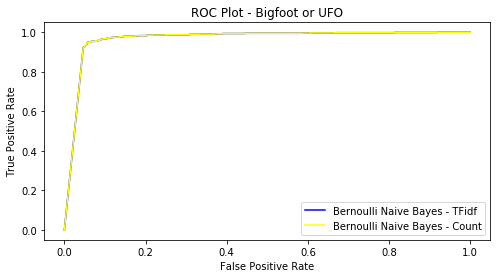

In [200]:
bnb_probs = clf.predict_proba(X_test)[:, 1]
bnb_fpr, bnb_tpr, bnb_thresholds = roc_curve(y_test, bnb_probs)

bnb_probs2 = clf2.predict_proba(X_test)[:, 1]
bnb_fpr2, bnb_tpr2, bnb_thresholds2 = roc_curve(yc_test, bnb_probs2)

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(bnb_fpr, bnb_tpr, color = 'blue', label='Bernoulli Naive Bayes - TFidf')
ax.plot(bnb_fpr2, bnb_tpr2, color = 'yellow', label='Bernoulli Naive Bayes - Count')
# ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot - Bigfoot or UFO')
ax.legend(loc='lower right');



In [201]:
# tfidf vectorizer
roc_auc_score(y_test, bnb_probs)

0.9661260021868845

In [211]:
# count vectorizer - same as tfidf
roc_auc_score(yc_test, bnb_probs2)

0.9661260021868845

## Multinomial Naïve Bayes Classifier

In [89]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [202]:
mnb2 = MultinomialNB()
mnb2.fit(Xc_train, yc_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [91]:
mnb_probs = mnb.predict_proba(X_test)[:, 1]
mnb_fpr, mnb_tpr, mnb_thresholds = roc_curve(y_test, mnb_probs)

In [203]:
mnb2_probs = mnb2.predict_proba(Xc_test)[:, 1]
mnb2_fpr, mnb2_tpr, mnb2_thresholds = roc_curve(yc_test, mnb2_probs)

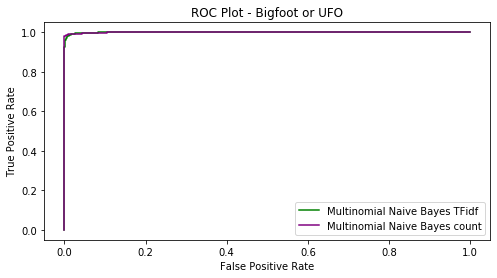

In [204]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(mnb_fpr, mnb_tpr, color = 'green', label='Multinomial Naive Bayes TFidf')
ax.plot(mnb2_fpr, mnb2_tpr, color = 'purple', label='Multinomial Naive Bayes count')
# ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot - Bigfoot or UFO')
ax.legend(loc='lower right');

In [93]:
# tfidf vectorizer 
roc_auc_score(y_test, mnb_probs)

0.9992277766782067

In [205]:
# count vectorizer - slightly better than tfidf vectorizer
roc_auc_score(yc_test, mnb2_probs)

0.9992515706741164

## Random Forest Classifier

In [83]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=42)
rfc.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [208]:
rfc2 = RandomForestClassifier(max_depth=2, random_state=42)
rfc2.fit(Xc_train, yc_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

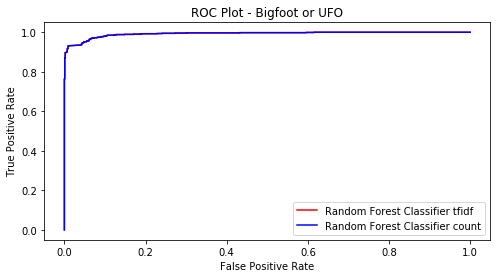

In [209]:
rfc_probs = rfc.predict_proba(X_test)[:, 1]
rfc_fpr, rfc_tpr, rfc_thresholds = roc_curve(y_test, rfc_probs)

rfc_probs2 = rfc2.predict_proba(Xc_test)[:, 1]
rfc_fpr2, rfc_tpr2, rfc_thresholds2 = roc_curve(yc_test, rfc_probs2)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rfc_fpr, rfc_tpr, color = 'red', label='Random Forest Classifier tfidf')
ax.plot(rfc_fpr, rfc_tpr, color = 'blue', label='Random Forest Classifier count')
# ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot - Bigfoot or UFO')
ax.legend(loc='lower right');

In [85]:
# tfidf vectorizer slightly beter than count vectorizer
roc_auc_score(y_test, rfc_probs)

0.9922274749270767

In [210]:
# count vectorizer
roc_auc_score(yc_test, rfc_probs2)

0.9922209856554651

## RFC vs BNB vs MNB

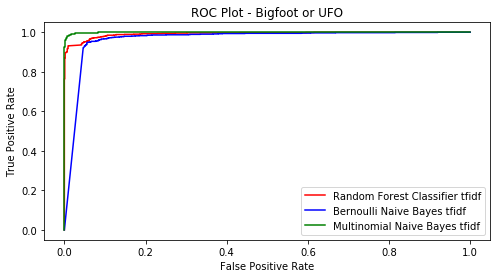

In [212]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rfc_fpr, rfc_tpr, color = 'red', label='Random Forest Classifier tfidf')
ax.plot(bnb_fpr, bnb_tpr, color = 'blue', label='Bernoulli Naive Bayes tfidf')
ax.plot(mnb_fpr, mnb_tpr, color = 'green', label='Multinomial Naive Bayes tfidf')
# ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot - Bigfoot or UFO')
ax.legend(loc='lower right');

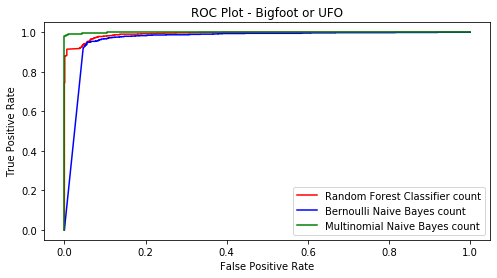

In [214]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rfc_fpr2, rfc_tpr2, color = 'red', label='Random Forest Classifier count')
ax.plot(bnb_fpr2, bnb_tpr2, color = 'blue', label='Bernoulli Naive Bayes count')
ax.plot(mnb2_fpr, mnb2_tpr, color = 'green', label='Multinomial Naive Bayes count')
# ax.plot(x, x, color='black', linestyle='-.')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Plot - Bigfoot or UFO')
ax.legend(loc='lower right');